In [1]:
import numpy as np
import pandas as pd
import pulp
import itertools
from math import radians
import scipy as sp
from sklearn.neighbors import DistanceMetric
import matplotlib.pyplot as plt

In [2]:
# import dataframe which contains demand locations co-ordinates
df = pd.read_csv('Demands.csv')
df

,latitude,longitude,demand
0,42.368197,-71.019922,13
1,41.927897,-70.141155,14
2,42.306619,-71.473414,10
3,41.982628,-71.790283,16
4,42.792484,-71.404969,15
5,42.722427,-71.368172,17
6,42.752336,-71.705351,15
7,41.677468,-71.308487,15
8,41.463087,-70.631341,18
9,42.840534,-70.956215,11


In [3]:
# adding 3 potential warehouse locations coordinates
W_1 = pd.DataFrame({'latitude':[42.340335], 'longitude':[-71.131830], 'demand':[0]})
W_2 = pd.DataFrame({'latitude':[42.710020], 'longitude':[-71.740000], 'demand':[0]})
W_3 = pd.DataFrame({'latitude':[41.600241], 'longitude':[-70.372297], 'demand':[0]})

In [4]:
# new dataframe with potential warehouse locations
df1 = pd.concat([W_1, df]).reset_index(drop = True)
df2 = pd.concat([W_2, df]).reset_index(drop = True)
df3 = pd.concat([W_3, df]).reset_index(drop = True)

In [5]:
# function for creating distance matrix for each warehouse locations
def get_dist_matrix(df):

    df['latitude_rad'] = np.radians(df['latitude'])
    df['longitude_rad'] = np.radians(df['longitude'])
    df[['latitude_rad','longitude_rad']].to_numpy()
    dist = DistanceMetric.get_metric('haversine')
    distance = pd.DataFrame(dist.pairwise(df[['latitude_rad','longitude_rad']].to_numpy())*6373,  columns=df.index.unique(), index=df.index.unique())
    return distance

In [6]:
# function for solving LP with pulp
def get_min_dist(distance,vehicle_count,customer_count,vehicle_capacity,df,vehicle_range):
    for vehicle_count in range(1,vehicle_count+1):

        # definition of LpProblem
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        # definition of variables which are 0/1(decisiion variables if a route is travelled or not)
        x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

        # add objective function (minimizing travel distances of all the vehicles)
        problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                              for k in range(vehicle_count) 
                              for j in range(customer_count) 
                              for i in range (customer_count))

        # s.t constraints
        # constraint 1 - only 1 visit to every demand point
        for j in range(1, customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(customer_count) 
                                  for k in range(vehicle_count)) == 1 

        # constraint 2 - departing from depot(warehouse node-0)
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

        # constraint 3 - no of vehicles entering and leaving a demand point is same
        for k in range(vehicle_count):
            for j in range(customer_count):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                      for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

        # constraint 4 - capacity constraint, delivery capacity must not exceed vehicle capacity
        for k in range(vehicle_count):
            problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 
       

        # constraint 5 - eliminating subtours()
        subtours = []
        for i in range(2,customer_count):
             subtours += itertools.combinations(range(1,customer_count), i)

        for s in subtours:
            problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

        # constraint 6 - maximum vehicle range constraint
        for k in range(vehicle_count):  
            problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0 
                                  for i in range(customer_count) 
                                  for j in range (1,customer_count)) <= vehicle_range
        
        # print vehicle_count which needed for solving problem
        # print calculated minimum distance value
        if problem.solve() == 1:
            print('Vehicle Requirement:', vehicle_count)
            print('Total route distance kms:', pulp.value(problem.objective))
            plt.figure(figsize=(8,8))
            for i in range(customer_count):    
                if i == 0:
                    plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
                    plt.text(df.latitude[i], df.longitude[i], "warehouse", fontsize=12)
                else:
                    plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
                    plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

            for k in range(vehicle_count):
                for i in range(customer_count):
                    for j in range(customer_count):
                        if i != j and pulp.value(x[i][j][k]) == 1:
                            plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")
            plot=plt.show
            return vehicle_count, pulp.value(problem.objective),plot
            break
            

In [7]:
def get_warehouse_optimal_dist(df,vehicle_count,vehicle_range,vehicle_capacity,customer_count=len(df)):
    dist_mat = get_dist_matrix(df)
    result = get_min_dist(dist_mat,vehicle_count,customer_count,vehicle_capacity,df,vehicle_range)
    return result

Vehicle Requirement: 3
Total route distance kms: 615.0423426175716
Vehicle Requirement: 3
Total route distance kms: 962.8300211240776
Vehicle Requirement: 4
Total route distance kms: 1004.9452297046003
CPU times: user 892 ms, sys: 101 ms, total: 993 ms
Wall time: 58.6 s


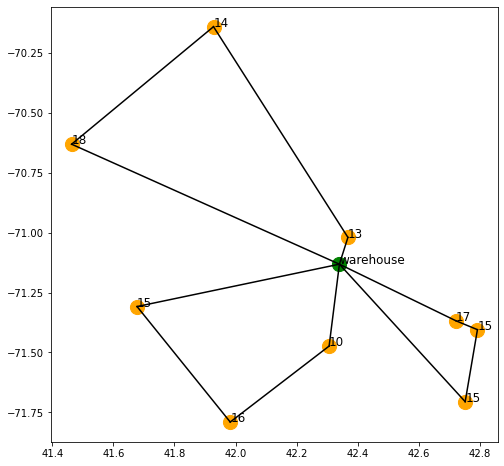

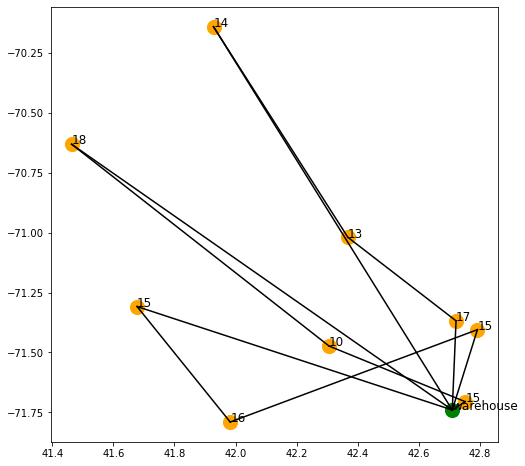

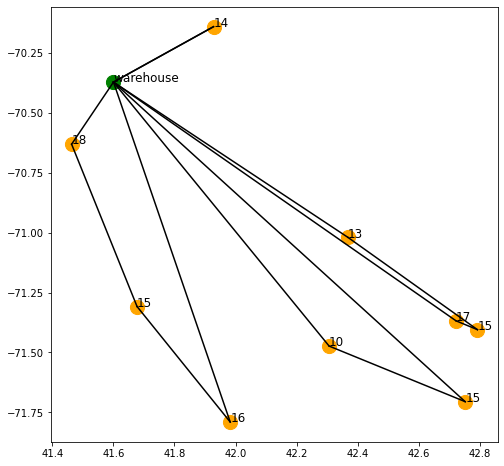

In [8]:
%%time

W1_vehicles,W1_route,W1_plot = get_warehouse_optimal_dist(df1,vehicle_count=4,vehicle_range=180,vehicle_capacity=50)

W2_vehicles,W2_route,W2_plot = get_warehouse_optimal_dist(df2,vehicle_count=4,vehicle_range=180,vehicle_capacity=50)

W3_vehicles,W3_route,W3_plot = get_warehouse_optimal_dist(df3,vehicle_count=4,vehicle_range=180,vehicle_capacity=50)

In [10]:
# appending distances to a list
W_Routes = [W1_route,W2_route,W3_route]
W_Routes

[615.0423426175716, 962.8300211240776, 1004.9452297046003]

In [11]:
# appending vehicle requirements list
W_Vehicles = [W1_vehicles,W2_vehicles,W3_vehicles]
W_Vehicles

[3, 3, 4]